# APIs para modelos de Machine Learning

## Introducción

En este notebook vamos a ver cómo podemos exponer un modelo de Machine Learning a través de una API. Para ello, vamos a utilizar la librería `fastapi` que nos permite crear APIs de forma sencilla y rápida. También trabajaremos con scikit-learn para entrenar un modelo de clasificación y guardarlo en disco para luego exponerlo a través de la API.

Utilizaremos el dataset de UCI llamado `adult` que contiene información sobre personas y su salario. El objetivo es predecir si una persona gana más de 50k al año o no.

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
#print(adult.metadata) 
  
# variable information 
#adult.variables 

En este ejercicio consideraremos tres componentes importantes en la creación de un modelo de una clasificación supervisada. Decimos que es supervisada porque el modelo se entrena con ejemplos que ya tienen la etiqueta que queremos predecir.

1. **Preprocesamiento de datos**: En esta etapa vamos a cargar el dataset, limpiarlo y transformar las variables categóricas en numéricas.

2. **Entrenamiento del modelo**: Utilizaremos un modelo de clasificación llamado `RandomForestClassifier` que se encuentra en la librería `scikit-learn`. Este modelo es un ensamble de árboles de decisión.

3. **Predicción**: Finalmente, vamos a exponer el modelo a través de una API para que cualquier persona pueda hacer predicciones.


Compilaremos estas tres componentes a traves de un Pipeline de scikit-learn, es muy importante tener en cuenta que este proceso aplica para cualquier modelo de clasificación supervisada, LO QUE IMPLICA QUE PUEDE REUTILIZARSE Y REVISARSE CUANDO ESTUDIE OTROS MODELOS DE MACHINE LEARNING.

## Como funciona un modelo de clasificación supervisada

Un modelo de clasificación supervisada es un algoritmo que aprende a predecir la etiqueta de una variable objetivo a partir de un conjunto de variables predictoras. En nuestro caso, queremos predecir si una persona gana más de 50k al año o no. Por lo tanto, la variable objetivo es `income` y las variables predictoras son `age`, `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `capital-gain`, `capital-loss`, `hours-per-week` y `native-country`.

La idea es que al exponer datos que el modelo no ha visto antes, pueda predecir la etiqueta de la variable objetivo. Por eso decimos que el modelo aprendió a partir de ejemplos previos.

### Exploracion de datos

Vamos a cargar el dataset y ver algunas estadísticas descriptivas.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Transformación de los datos en un dataframe de pandas

df = pd.DataFrame(X, columns=adult.variables.name[:-1])
df['Income'] = y

# Visualización de los primeros registros
df.head()

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
### Análisis exploratorio de datos

# Información general del dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
### Análisis de valores nulos

# Verificación de valores nulos

df.isnull().sum()

name
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
Income              0
dtype: int64

In [6]:
### Análisis de valores duplicados

# Verificación de valores duplicados

df=df.drop_duplicates()
df

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [7]:
### Análisis de la variable objetivo

# Distribución de la variable objetivo

df['Income'].value_counts()



Income
<=50K     24698
<=50K.    12430
>50K       7839
>50K.      3846
Name: count, dtype: int64

In [8]:
(df['Income']=='>50K').value_counts()

Income
False    40974
True      7839
Name: count, dtype: int64

In [9]:
### Arreglo de la variable objetivo

# Reemplazo de los valores de la variable objetivo

df['Income'] = df['Income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
df['Income'].value_counts()

C:\Users\danie\AppData\Local\Temp\ipykernel_40212\797159872.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Income'] = df['Income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})


Income
0    37128
1    11685
Name: count, dtype: int64

In [10]:
### Análisis de las variables numéricas

# Estadísticas descriptivas de las variables numéricas

df.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Income
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051,0.239383
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954,0.426711
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [11]:
### Análisis de las variables categóricas

# Estadísticas descriptivas de las variables categóricas

df.describe(include='object')

name,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,47850,48813,48813,47847,48813,48813,48813,48539
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33879,15777,22372,6167,19709,41736,32631,43810


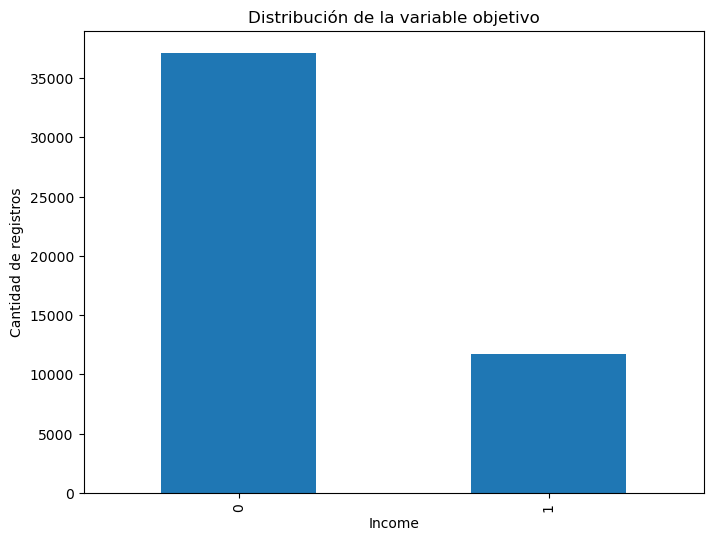

In [12]:
### Visualización de la variable objetivo

# Gráfico de barras de la variable objetivo

plt.figure(figsize=(8, 6))
plt.title('Distribución de la variable objetivo')
plt.xlabel('Ingresos')
plt.ylabel('Cantidad de registros')
df['Income'].value_counts().plot(kind='bar')
plt.show()

In [13]:
### tratamiento de variables 

# Transformación de las variables categóricas

df['workclass'].value_counts()

workclass
Private             33879
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [14]:
!pip install scikit-learn

In [15]:
#### preprocesamiento de datos

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Separación de las variables predictoras y la variable objetivo

X = df.drop('Income', axis=1)
y = df['Income']

print(X.info())


<class 'pandas.core.frame.DataFrame'>
Index: 48813 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48813 non-null  int64 
 1   workclass       47850 non-null  object
 2   fnlwgt          48813 non-null  int64 
 3   education       48813 non-null  object
 4   education-num   48813 non-null  int64 
 5   marital-status  48813 non-null  object
 6   occupation      47847 non-null  object
 7   relationship    48813 non-null  object
 8   race            48813 non-null  object
 9   sex             48813 non-null  object
 10  capital-gain    48813 non-null  int64 
 11  capital-loss    48813 non-null  int64 
 12  hours-per-week  48813 non-null  int64 
 13  native-country  48539 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.6+ MB
None


In [16]:
### En X buscamos las columnas categoricas y las numericas

# Identificación de las columnas numéricas y categóricas

columnas_numericas = X.select_dtypes(exclude='object').columns
columnas_numericas

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name')

In [17]:
columnas_categoricas = X.select_dtypes(include='object').columns
columnas_categoricas

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name')

In [18]:
### Definimos los pasos para el preprocesamiento de los datos

transfomacion_OHE = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

### Ejemplo de uso

print(transfomacion_OHE.fit_transform(X[['workclass']]))

print(transfomacion_OHE.fit_transform(X[columnas_categoricas]).shape)



[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(48813, 105)


In [19]:
### SimpleImputer

transformacion_nan= SimpleImputer(strategy='constant', fill_value='Desconocido')

pd.DataFrame(transformacion_nan.fit_transform(X[['occupation']])).value_counts()

0                
Prof-specialty       6167
Craft-repair         6107
Exec-managerial      6084
Adm-clerical         5608
Sales                5504
Other-service        4919
Machine-op-inspct    3019
Transport-moving     2355
Handlers-cleaners    2071
?                    1843
Farming-fishing      1487
Tech-support         1445
Protective-serv       983
Desconocido           966
Priv-house-serv       240
Armed-Forces           15
Name: count, dtype: int64

In [20]:
### Normalización de las variables numéricas

transformacion_escalar = StandardScaler()

pd.DataFrame(transformacion_escalar.fit_transform(X[columnas_numericas])).describe()

,0,1,2,3,4,5
count,4.881300e+04,4.881300e+04,4.881300e+04,4.881300e+04,4.881300e+04,4.881300e+04
mean,-2.352318e-16,-3.726445e-17,-2.403266e-16,1.353747e-17,-5.254869e-17,2.039355e-16
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.579077e+00,-1.679680e+00,-3.532247e+00,-1.448474e-01,-2.171946e-01,-3.181793e+00
25%,-7.766762e-01,-6.828540e-01,-4.196854e-01,-1.448474e-01,-2.171946e-01,-3.430366e-02
50%,-1.201666e-01,-1.091604e-01,-3.061518e-02,-1.448474e-01,-2.171946e-01,-3.430366e-02
75%,6.822339e-01,4.540696e-01,7.475252e-01,-1.448474e-01,-2.171946e-01,3.692206e-01
max,3.745945e+00,1.231694e+01,2.303806e+00,1.327044e+01,1.058867e+01,4.727283e+00


In [21]:
### Transformación de las variables
from sklearn.pipeline import Pipeline

# Creación de los pasos para el preprocesamiento

pasos = [
    ('imputacion', transformacion_nan),
    ('codificacion', transfomacion_OHE),]

# Creación del preprocesador

preprocesador_categorical = ColumnTransformer(
    transformers=[('CAT',Pipeline(pasos), columnas_categoricas)])

preprocsador_numerico = ColumnTransformer(
    transformers=[('escalar', transformacion_escalar, columnas_numericas)])


Transformacion_Columnas = ColumnTransformer(
    transformers=[
        ('num', preprocsador_numerico, columnas_numericas),
        ('cat', preprocesador_categorical, columnas_categoricas)
    ])

Transformacion_Columnas.fit(X)

pd.DataFrame(Transformacion_Columnas.transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,0.025724,-1.061993,1.136595,0.146804,-0.217195,-0.034304,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.828125,-1.007118,1.136595,-0.144847,-0.217195,-2.213335,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.047221,0.245993,-0.419685,-0.144847,-0.217195,-0.034304,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.046961,0.426618,-1.197826,-0.144847,-0.217195,-0.034304,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.776676,1.408464,1.136595,-0.144847,-0.217195,-0.034304,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
import joblib 

joblib.dump(Transformacion_Columnas, 'preprocesador.gz')

['preprocesador.gz']

In [23]:
new_column_transformer = joblib.load('preprocesador.gz')
new_column_transformer


ColumnTransformer(transformers=[('num',
                                 ColumnTransformer(transformers=[('escalar',
                                                                  StandardScaler(),
                                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))]),
                                 Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name')),
                                ('cat',
                                 ColumnTransf...
                                                                                  ('codificacion',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False))]),
                                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))])

In [24]:
columnas_numericas=Transformacion_Columnas.transformers_[0][2]
columnas_numericas

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name')

In [25]:
columnas_categoricas_transformadas=Transformacion_Columnas.named_transformers_['cat'].named_transformers_['CAT'][-1].get_feature_names_out()


columnas_categoricas_transformadas

array(['x0_?', 'x0_Desconocido', 'x0_Federal-gov', 'x0_Local-gov',
       'x0_Never-worked', 'x0_Private', 'x0_Self-emp-inc',
       'x0_Self-emp-not-inc', 'x0_State-gov', 'x0_Without-pay', 'x1_10th',
       'x1_11th', 'x1_12th', 'x1_1st-4th', 'x1_5th-6th', 'x1_7th-8th',
       'x1_9th', 'x1_Assoc-acdm', 'x1_Assoc-voc', 'x1_Bachelors',
       'x1_Doctorate', 'x1_HS-grad', 'x1_Masters', 'x1_Preschool',
       'x1_Prof-school', 'x1_Some-college', 'x2_Divorced',
       'x2_Married-AF-spouse', 'x2_Married-civ-spouse',
       'x2_Married-spouse-absent', 'x2_Never-married', 'x2_Separated',
       'x2_Widowed', 'x3_?', 'x3_Adm-clerical', 'x3_Armed-Forces',
       'x3_Craft-repair', 'x3_Desconocido', 'x3_Exec-managerial',
       'x3_Farming-fishing', 'x3_Handlers-cleaners',
       'x3_Machine-op-inspct', 'x3_Other-service', 'x3_Priv-house-serv',
       'x3_Prof-specialty', 'x3_Protective-serv', 'x3_Sales',
       'x3_Tech-support', 'x3_Transport-moving', 'x4_Husband',
       'x4_Not-in-family'

In [26]:
### Entrenamos varios modelos random forest para decidir si una persona gana mas de 50k y escogeremos el mejor modelo.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Separación de los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creación del modelo

parametros = {'n_estimators': [100, 200, 500],
                'max_depth': [5, 10,  20],
                'min_samples_split': [5, 10,  20],
                'min_samples_leaf': [1, 2, 10]}

modelo = RandomForestClassifier(random_state=42)


# Búsqueda de los mejores hiperparámetros

grid = GridSearchCV(modelo, param_grid=parametros, cv=5, n_jobs=-1)

grid.fit(Transformacion_Columnas.transform(X_train), y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 10],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 200, 500]})

In [27]:
## Evaluación del modelo

best_model = grid.best_estimator_
print('Mejores hiperparámetros:', grid.best_params_)

## Predicciones
y_pred = best_model.predict(Transformacion_Columnas.transform(X_test))

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.8652007648183556

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     11078
           1       0.80      0.60      0.68      3566

    accuracy                           0.87     14644
   macro avg       0.84      0.77      0.80     14644
weighted avg       0.86      0.87      0.86     14644


Confusion Matrix:
 [[10534   544]
 [ 1430  2136]]


In [28]:
### Guardamos el mejor modelo

joblib.dump(best_model, 'mejor_modelo.gz')

### Crear un pipeline para preprocesar los datos, entrenar el modelo y predecir nuevos datos

from sklearn.pipeline import Pipeline

# Creación del pipeline

pipeline = Pipeline(steps=[('preprocesador', Transformacion_Columnas),
                            ('modelo', best_model)])

# Entrenamiento del pipeline

pipeline.fit(X_train, y_train)

# Predicción de nuevos datos

nuevos_datos = X_test[:5]

pipeline.predict(nuevos_datos)



array([0, 0, 0, 0, 0], dtype=int64)

In [29]:
pipeline

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('escalar',
                                                                                   StandardScaler(),
                                                                                   Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))]),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object',...
                                                                                   Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name'))])),
                ('modelo',
                 RandomForestClassifier(max_depth=20, min_samples_split=10,
                                        random_state=42))])

In [30]:
### Guardamos el pipeline

joblib.dump(pipeline, 'pipeline_total.gz')


['pipeline_total.gz']

In [31]:
nuevos_datos.to_json()

'{"age":{"14706":62,"15079":30,"17844":46,"11736":41,"35397":24},"workclass":{"14706":"Private","15079":"Private","17844":"Private","11736":"Private","35397":"Private"},"fnlwgt":{"14706":96099,"15079":174201,"17844":186078,"11736":66118,"35397":199005},"education":{"14706":"HS-grad","15079":"Some-college","17844":"Some-college","11736":"Bachelors","35397":"HS-grad"},"education-num":{"14706":9,"15079":10,"17844":10,"11736":13,"35397":9},"marital-status":{"14706":"Never-married","15079":"Never-married","17844":"Never-married","11736":"Divorced","35397":"Never-married"},"occupation":{"14706":"Craft-repair","15079":"Craft-repair","17844":"Machine-op-inspct","11736":"Prof-specialty","35397":"Other-service"},"relationship":{"14706":"Not-in-family","15079":"Own-child","17844":"Not-in-family","11736":"Own-child","35397":"Own-child"},"race":{"14706":"White","15079":"White","17844":"White","11736":"White","35397":"White"},"sex":{"14706":"Male","15079":"Male","17844":"Female","11736":"Female","35